# Diferencias Finitas

El método de diferencias finitas corresponde a una aproximación discreta del dominio del problema, generando un sistema de ecuaciones para tal efecto. Tanto Ecuaciones diferenciales ordinarias como parciales pueden ser resueltas numéricamente con este método.

Tomemos las fórmulas de diferencias finitas centradas para estimar la primera y segunda derivada de nuestra función a aproximar,

$$y'(t) = \frac{y(t+h)-y(t-h)}{2h} - \frac{h^2}{6}y'''(c)$$

$$y''(t) = \frac{y(t+h)-2y(t) + y(t-h)}{h^2} + \frac{h^2}{12}y''''(c)$$

y las reemplazaremos en nuestros problemas que involucran ecuaciones diferenciales. Si el problema original es lineal, el sistema de ecuaciones a resolver será lineal y podemos aproximarlo por eliminación gaussiana o por métodos iterativos. Problemas no lineales generaran sistemas de ecuaciones no lineales y habrá que resolverlos de otra forma.

## 1. Problemas de Valor de Frontera  (BVP) lineales

Por ejemplo el siguiente BVP puede ser resuelto utilizando diferencias finitas.

\begin{align*}
y'' = 4y \\
y(0) = 1\\
y(1) = 3
\end{align*}

Al reemplazar las derivadas por sus aproximaciones obtenemos que

\begin{align*}
\frac{w_{i+1} - 2w_i + w_{i-1}}{h^2} - 4w_i &= 0\\
\Rightarrow w_{i-1} + (-4h^2-2)w_i + w_{i+1} &= 0
\end{align*}

Si elegimos una aproximación de $n=3$ estimaciones el tamaño del intervalo es $h = \frac{1}{n+1} = \frac{1}{4}$ con tres ecuaciones. En general, como sabemos las condiciones de borde, nosotros buscamos una aproximación en $n$ puntos equiespaciados sin contar los extremos, luego para saber el tamaño del intervalo usamos la fórmula general $h = \frac{b-a}{n+1}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

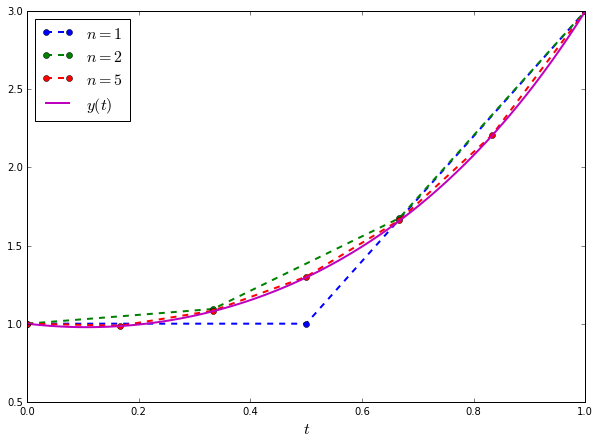

In [2]:
# Rango de tiempo
tt = np.linspace(0, 1, 100)

# Solución Analítica
def y(t):
    return (np.exp(-2*t)*(-3*np.exp(2)+np.exp(4)-np.exp(4*t)+ 3*np.exp(2+4*t)))/(-1+np.exp(4))

yy = y(tt)


# Matriz de diferencias finitas que depende de n
def DiffMatrix(n, h):
    m = np.zeros((n,n), dtype=float)
    np.fill_diagonal(m, -4.0*h**2.0-2)
    dix, diy = np.diag_indices(n)
    dix = dix[:-1]
    diy = diy[:-1] + 1
    m[(dix, diy)] = 1
    dix = dix + 1
    diy = diy - 1
    m[(dix, diy)] = 1
    return m

plt.figure(figsize=(10,7))
# Para distintas precisiones
for n in [1, 2, 5]:
    # Calcular tamaño del intervalo
    h = 1.0/(n + 1.0)
    # Armar vector de coeficientes
    b = np.zeros((n))
    b[0] = -1
    b[-1] = -3
    # Resolver el sistema A*w = b
    # A es la matriz de diferencias finitas
    # w el vector de aproximaciones finitas
    A = DiffMatrix(n, h)
    w = np.concatenate(([1], np.linalg.solve(A, b), [3]))
    _t = np.linspace(0, 1, n+2)
    # Plot aproximación
    plt.plot(_t, w, 'o--',lw=2, label="$n ="+str(n)+"$")
                       
# Plots
plt.plot(tt, yy, 'm', lw=2, label="$y(t)$")
plt.legend(loc='best', fontsize=16)
plt.xlabel("$t$", fontsize=16)
plt.show()

In [3]:
print(A)

[[-2.11111111  1.          0.          0.          0.        ]
 [ 1.         -2.11111111  1.          0.          0.        ]
 [ 0.          1.         -2.11111111  1.          0.        ]
 [ 0.          0.          1.         -2.11111111  1.        ]
 [ 0.          0.          0.          1.         -2.11111111]]


Los errores de éste método son dos principalmente:

1. Truncamiento de las fórmulas de diferencias finitas (es decir, cuando despreciamos los términos de orden superior que provienen de la Serie de Taylor que utilizamos para definir las fórmulas).
2. El error de solucionar numéricamente el sistema de ecuaciones lineales.

Las fórmulas centradas de diferencia finitas tienen un error proporcional a $h^2$. Nuestro método irá disminuyendo el error a medida que aumentamos la cantidad de subintervalos $n+1$, es decir, a medida que disminuimos $h$, y por lo tanto el error decrece como $\mathcal{O}(n^{-2})$.

Recordemos que para entender gráficamente cómo un error decrece (o crece) es conveniente establecer relaciones utilizando gráficos loglog, donde la pendiente del gráfico indica el exponente para la regla de cambio del error respecto a la variable independiente $n$.

Se puede observar que efectivamente la pendiente de este gráfico es -2, lo que confirma la regla del error que hemos calculado.

/usr/lib64/python3.4/site-packages/scipy/interpolate/polyint.py:510: RuntimeWarning: divide by zero encountered in reciprocal
  self.wi **= -1
/usr/lib64/python3.4/site-packages/scipy/interpolate/polyint.py:510: RuntimeWarning: overflow encountered in reciprocal
  self.wi **= -1
/usr/lib64/python3.4/site-packages/scipy/interpolate/polyint.py:605: RuntimeWarning: overflow encountered in true_divide
  c = self.wi/c
/usr/lib/python3.4/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in absolute


pendiente: -1.92040335823


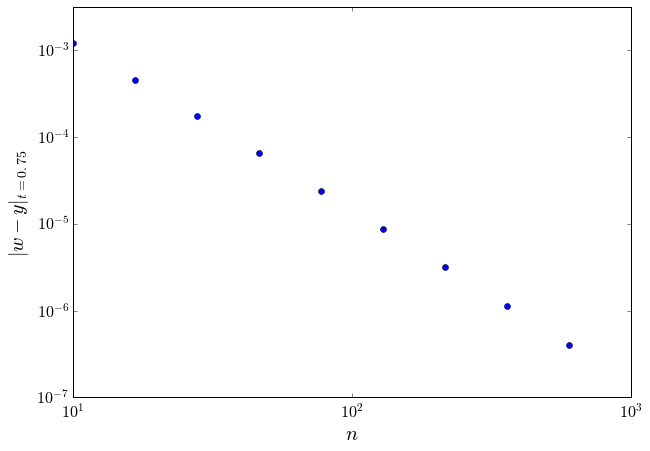

In [34]:
from scipy.interpolate import BarycentricInterpolator

y_data = y(0.75)
exp = np.linspace(1, 3, 10)
N = np.round(np.power(10, exp))
err = []

for n in N:
    n = int(n)
    h = 1.0/(n + 1.0)
    A = DiffMatrix(n, h)
    b = np.zeros((n))
    b[0] = -1
    b[-1] = -3
    w = np.concatenate(([1], np.linalg.solve(A, b), [3]))
    _t = np.linspace(0, 1, n+2)
    f = BarycentricInterpolator(_t, w)
    err.append(np.abs(f(0.75) - y(0.75)))

logerr = np.log10(err)
plt.figure(figsize=(10,7))
plt.plot(exp, logerr, 'bo')
slope = (logerr[1] - logerr[0]) / (exp[1] - exp[0])
print("pendiente:",slope)
plt.xlabel("$n$",fontsize=20)
plt.ylabel("$|w-y|_{t=0.75}$",fontsize=20)
exp_n = [1,2,3]
plt.xticks(exp_n, ["$10^{"+str(i)+"}$" for i in exp_n], fontsize=16)
exp_error = [-7, -6, -5, -4 , -3] 
plt.yticks(exp_error, ["$10^{"+str(i)+"}$" for i in exp_error], fontsize=16)
plt.show()

A continuación otro ejemplo de BVP, esta vez note que hay involucrada una función explícitamente dependiente del tiempo. Basta con evaluarla en la grilla de tiempo según sea necesario, la consecuencia directa es que el vector que solía contener sólo condiciones de borde ahora tendrá estos valores asociados a $f(t)$.
$$\begin{align*}
\ddot{y}(t) &= 2\cos(t) - \dot{y}(t)\\
y(0) &= -1\\
y(\pi) &= 1
\end{align*}$$

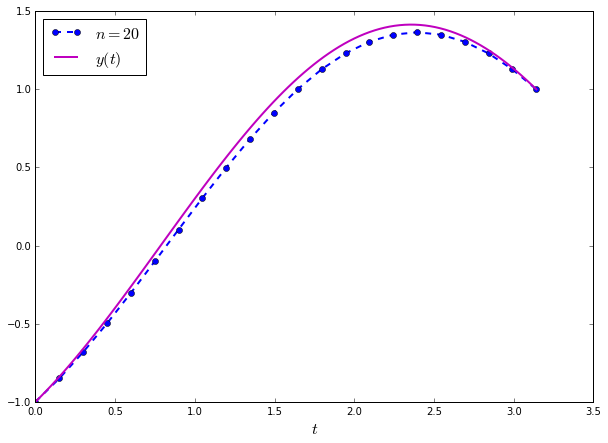

In [77]:
# Rango de tiempo
tt = np.linspace(0, np.pi, 100)

# Solución Analítica
def y(t):
    return np.sin(t) - np.cos(t)
y0 = y(0)
yM = y(np.pi)

yy = y(tt)

# Matriz de diferencias finitas que depende de n
def DiffMatrix(n, h):
    m = np.zeros((n,n), dtype=float)
    m += np.diag((-h-2)*np.ones(n), k=0)
    m += np.diag(np.ones(n-1), k=-1)
    m += np.diag((1+h)*np.ones(n-1), k=1)
    return m

plt.figure(figsize=(10,7))
# Para distintas precisiones
for n in [20]:
    # Calcular tamaño del intervalo
    h = (np.pi - 0.0)/(n + 1.0)
    t = np.arange(0, np.pi+h, h)
    # Armar vector de coeficientes
    b = np.zeros((n))
    b[0] = 2.0*(h**2)*np.cos(t[1]) - y0
    b[-1] = 2.0*(h**2)*np.cos(t[-2]) - (1+h)*yM
    b[1:-1] = 2.0*(h**2)*np.cos(t[2:-2])
    # Resolver el sistema A*w = b
    # A es la matriz de diferencias finitas
    # w el vector de aproximaciones finitas
    A = DiffMatrix(n, h)
    w = np.concatenate(([y0], np.linalg.solve(A, b), [yM]))
    # Plot aproximación
    plt.plot(t, w, 'o--',lw=2, label="$n ="+str(n)+"$")
                       
# Plots
plt.plot(tt, yy, 'm', lw=2, label="$y(t)$")
plt.legend(loc='best', fontsize=16)
plt.xlabel("$t$", fontsize=16)
plt.show()

## 2. Problemas de Valor de Frontera No Lineales

Si introducimos no linealidades a nuestras ecuaciones diferenciales, resolverlas numéricamente implicará replantear el sistema de ecuaciones para dejarla en función de $w$ y podemos en cambio resolver $F(w) = 0$. Por ejemplo podemos usar el Método de Newton multivariado, y para ello necesitamos la matriz Jacobiana de $F$...

No olvidar la fórmula del jacobiano de una función $F$, que no es más que la matriz de derivadas parciales de $F$

\begin{bmatrix}
\cfrac{\partial F_1}{\partial w_1} & \cdots & \cfrac{\partial F_1}{\partial w_n} \\
\vdots & \ddots & \vdots \\
\cfrac{\partial F_n}{\partial w_1} & \cdots & \cfrac{\partial F_n}{\partial w_n}
\end{bmatrix}

El método de Newton es $w^{k+1} = w^{k} - \partial F(w^k)^{-1} F(w^k)$. Pero, como siempre, encontrar la inversa del Jacobiano puede ser una operacion costosa y puede llevar a inestabilidades. Por lo que es mejor resolver para $\Delta w$ el sistema análogo $\partial F(w^k) \Delta w = -F(w^k)$

$$Ax=b$$

El siguiente problema puede ser resuelto con diferencias finitas y método de Newton:

\begin{align*}
y'' = y - y^2\\
y(0) = 1\\
y(1) = 4
\end{align*}

Reemplazando nuestras fórmulas de diferencias finitas y dejando todo al lado izquierdo obtenemos:

$$w_{i-1} - (2 + h^2)w_i + h^2w_i^2 + w_{i+1} = 0$$

Esto nos asegurará poder expresar el sistema de ecuaciones como una función que depende de las estimaciones $w$. Aparte, las ecuaciones para las condiciones de borde resultan ser:

$$y_a - (2+h^2)w_1 + h^2w_1^2 + w_2 = 0$$

$$w_{n-1} - (2+h^2)w_n + h^2w_n^2 + y_b = 0$$

Para encontrar la solución numérica $w$ debemos calcular tanto $F(w)$ como su jacobiano $\partial F$. $F(w)$ no es más que un vector que contiene las ecuaciones mencionadas anteriormente:

$$F\left[ \begin{array}{c}
w_{1} \\
w_{2}\\
\vdots \\
w_{n-1} \\
w_{n}\\ \end{array} \right] = \left[ \begin{array}{c}
y_a - (2+h^2)w_1 + h^2w_1^2 + w_2 \\
w_{1} - (2 + h^2)w_2 + h^2w_2^2 + w_{3} \\
\vdots \\
w_{n-2} - (2+h^2)w_{n-1} + h^2w_{n-1}^2 + w_{n} \\
w_{n-1} - (2+h^2)w_n + h^2w_n^2 + y_b \\ \end{array} \right]$$

Como se imaginarán el jacobiano de $F$ es hermoso. Hay que derivar parcialmente cada ecuación en $F$ respecto de cada variable $w_i$... Los detalles los dejamos al lector, pero para ejemplificar mostraremos las parciales de $F_1$ respecto a $w_i$.

\begin{align*}
\frac{\partial F_1}{\partial w_1} &=  -(2+h^2) + 2h^2w_1 \\
\frac{\partial F_1}{\partial w_2} &=  1 \\
\frac{\partial F_1}{\partial w_i} &=  0,\;\; \forall i \neq \{1, 2\}
\end{align*}

El jacobiano finalmente tendrá una forma tridiagonal. Ahora podemos resolver numéricamente $\Delta w$ e ir actualizando iterativamente $w$ como $w^{k+1} = w^{k} - \Delta w$

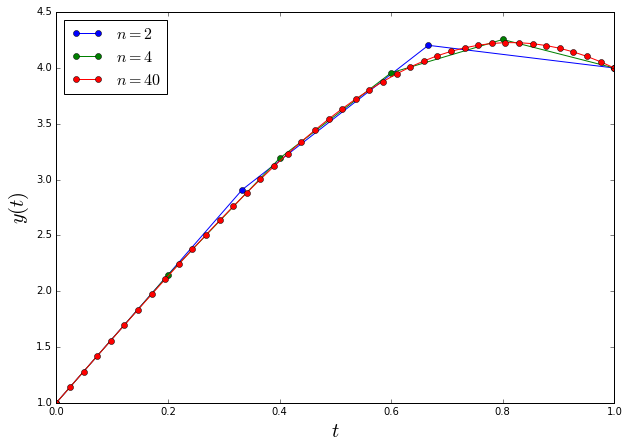

In [35]:
ya = 1
yb = 4
n_iter = 20

# Matriz de diferencias finitas que depende de n
def jacobian(n, w, h):
    m = np.zeros((n,n), dtype=float)
    np.fill_diagonal(m, 2.0*h**2.0 * w -2-h**2)
    dix, diy = np.diag_indices(n)
    dix = dix[:-1]
    diy = diy[:-1] + 1
    m[(dix, diy)] = 1
    dix = dix + 1
    diy = diy - 1
    m[(dix, diy)] = 1
    return m

# Función con el sistema de ecuaciones a la cual le encontraremos el cero
def f(n, w, h):
    y = np.zeros((n))
    y[0] = ya       - (2+h**2)*w[0]   + h**2*w[0]**2   + w[1]
    y[n-1] = w[n-2] - (2+h**2)*w[n-1] + h**2*w[n-1]**2 + yb
    for i in range(1, n-1):
        y[i] = w[i-1] - (2+h**2)*w[i] + h**2*w[i]**2 + w[i+1]
    return y

plt.figure(figsize=(10,7))
# Probar distintos intervalos
for n in [2, 4, 40]:
    h = 1.0 / (n + 1)
    t = np.linspace(0, 1, n+2)
    w = np.zeros((n))
    for i in range(n_iter):
        # wk+1 = wk - delta w
        w = w - np.linalg.solve(jacobian(n, w, h), f(n, w, h))
    plt.plot(t, np.concatenate([[ya],w,[yb]]), 'o-', label="$n = "+str(n)+"$")
plt.legend(loc='best', fontsize=16)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("$y(t)$", fontsize=20)
plt.show()

## 3. Condiciones de Borde

Es posible establecer diversas condiciones de borde para nuestro problema. Las más comunes son Dirichlet, Neumann, Robin y condiciones periódicas.

1. Las condiciones de **Dirichlet** buscan fijar un valor en específico para la función incógnita en los bordes.
2. Las condiciones de **Neumann** buscan análogamente fijar un valor de la derivada de la función incógnita en los bordes.
3. Las condiciones de **Robin** son una mezcla de ambas, una combinación de condiciones de Dirichlet y Neumann para algún borde.
4. Cabe destacar también condiciones periódicas, en donde se fuerza que la función en un borde sea igual a la función en el borde contrario.

Resolvamos la siguiente ecuación diferencial con condiciones mixtas (una Neumann y una Dirichlet):
\begin{align}
y''(x) &= y(x)-3x+\cos(2\pi x)\\
y'(0) &= 1 \\
y(1) &= 0 
\end{align}

Discretizando obtenemos:
\begin{align}
\frac{w_{i+1}-2w_i+w_{i-1}}{h^2} &= w_i - 3x_i + \cos(2\pi x_i)\\
w_{i+1} +(-2-h^2)w_i+w_{i-1} &= -3h^2x_i+ h^2\cos(2\pi x_i)
\end{align}
Esta ecuación será la forma general que tendrá nuestra matriz de diferenciación. Ahora veamos las condiciones de borde. La condición de Neumann corresponde al primer borde $x_0 = 0$, discretizando obtenemos:
\begin{align}
\frac{y_{1}-y_{0}}{h} &= 1\\
\Rightarrow y_{1} &= h+y_{0}
\end{align}

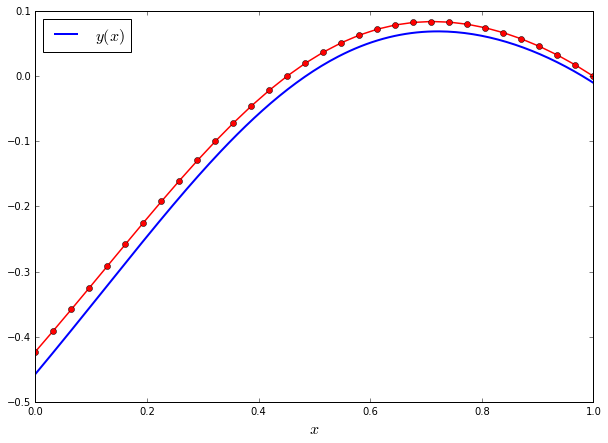

In [54]:
xx = np.linspace(0, 1, 200)
# Solución Analítica
def y(x):
    dem = -(1.+np.e**2.)*(1+4*np.pi**2.)
    num = np.exp(-x)*(2*np.e**2.-2*np.e**2.+2*np.exp(2.*x)
          +2.*np.exp(1.+2.*x)+12.*np.e*np.pi**2.-8.*np.e**2.*np.pi**2.
          +8.*np.exp(2.*x)*np.pi**2.+12.*np.exp(1.+2.*x)*np.pi**2.
          -3*np.exp(x)*x-3*np.exp(2+x)*x-12.*np.exp(x)*np.pi**2.*x
          -12*x*np.exp(2.+x)*np.pi**2.+np.exp(x)*np.cos(2.*np.pi*x)
          + np.exp(2.+x)*np.cos(2.*np.pi*x))
    return num/dem

yy = y(xx)

# Matriz de derivacion
def DiffMatrix(n, h):
    D = np.diag((-2-h**2)*np.ones(n),0) + np.diag(np.ones(n-1),-1) + np.diag(np.ones(n-1),1)
    D[0][0] = -1.-h**2.
    return D

n = 30
h = 1/(n+1)
x = np.linspace(0, 1, n+2)
b = (h**2)*(-3*x[1:-1]+np.cos(2*np.pi*x[1:-1]))
D = DiffMatrix(n, h)
b[0] += h
w = np.linalg.solve(D, b)
w = np.concatenate([[w[0]-h], w, [0]])

# Otra forma, despejando distinto la condición de Neumann
def DiffMatrix(n, h):
    D = np.diag((-2-h**2)*np.ones(n),0) + np.diag(np.ones(n-1),-1) + np.diag(np.ones(n-1),1)
    D[0][0] = 0
    return D

D = DiffMatrix(n, h)
b = (h**2)*(-3*x[1:-1]+np.cos(2*np.pi*x[1:-1]))
b[0] += h
w = np.linalg.solve(D, b)
w = np.concatenate([[w[0]-h], w, [0]])


plt.figure(figsize=(10,7))
plt.plot(xx, yy, lw=2, label="$y(x)$")
plt.plot(x, w, 'ro-', lw=1.5)
plt.legend(loc='best', fontsize=16)
plt.xlabel("$x$", fontsize=16)
plt.show()

El presente notebook ha sido creado para el curso ILI286 - Computación Científica 2, del Departamento de Informática, Universidad Técnica Federico Santa María. El material ha sido creado por Alejandro Sazo (asazo@alumnos.inf.utfsm.cl), y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactar al email especificado. Puede encontrar la última versión del código en https://github.com/asazo/CC2